In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, SGDRegressor, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression


In [4]:
os.chdir(r"/content/sample_data")

In [5]:
data = pd.read_csv("laptop_price.csv", encoding='latin-1')

In [6]:
display(data)

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1298,1316,Lenovo,Yoga 500-14ISK,2 in 1 Convertible,14.0,IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i7 6500U 2.5GHz,4GB,128GB SSD,Intel HD Graphics 520,Windows 10,1.8kg,638.00
1299,1317,Lenovo,Yoga 900-13ISK,2 in 1 Convertible,13.3,IPS Panel Quad HD+ / Touchscreen 3200x1800,Intel Core i7 6500U 2.5GHz,16GB,512GB SSD,Intel HD Graphics 520,Windows 10,1.3kg,1499.00
1300,1318,Lenovo,IdeaPad 100S-14IBR,Notebook,14.0,1366x768,Intel Celeron Dual Core N3050 1.6GHz,2GB,64GB Flash Storage,Intel HD Graphics,Windows 10,1.5kg,229.00
1301,1319,HP,15-AC110nv (i7-6500U/6GB/1TB/Radeon,Notebook,15.6,1366x768,Intel Core i7 6500U 2.5GHz,6GB,1TB HDD,AMD Radeon R5 M330,Windows 10,2.19kg,764.00


In [7]:
data.duplicated().sum()

0

In [8]:
data.isnull().sum()

,0
laptop_ID,0
Company,0
Product,0
TypeName,0
Inches,0
ScreenResolution,0
Cpu,0
Ram,0
Memory,0
Gpu,0


In [9]:
num_cols = data.select_dtypes("number").columns
cat_cols = data.select_dtypes("object").columns

In [10]:

# Define a function to extract the CPU information
def extract_cpu_info(cpu_string):
    parts_cpu = cpu_string.split()
    company_cpu = parts_cpu[0]  # First part is the company
    type_cpu = ' '.join(parts_cpu[1:-1])  # Everything after the first part except the last
    frequency = parts_cpu[-1].replace('GHz', '')  # Get the last part and remove 'GHz'

    # Convert frequency to float if possible
    try:
        frequency = float(frequency)
    except ValueError:
        frequency = None  # Handle cases where conversion fails

    return pd.Series([company_cpu, type_cpu, frequency])


# Define a function to extract the GPU information
def extract_GPU_info(GPU_string):
    parts_GPU = GPU_string.split()
    company_GPU = parts_GPU[0]
    type_GPU = ' '.join(parts_GPU[1:])
    return pd.Series([company_GPU, type_GPU])


# Apply the function to the 'Cpu' & 'Gpu' column and create new columns:
data[['CPU_Company', 'CPU_Type', 'CPU_Frequency (GHz)']] = data['Cpu'].apply(extract_cpu_info)
data[['GPU_Company', 'GPU_Type']] = data['Gpu'].apply(extract_GPU_info)


# Clean the Weight column
data['Ram'] = data['Ram'].str.replace('GB', '').astype(int)
data['Weight'] = data['Weight'].str.replace('kg', '').astype(float)


# Drop columns 'Cpu' & 'Gpu', because new columns were created for them:
data.drop(columns=['Cpu', 'Gpu', 'laptop_ID'], inplace=True)


# Reorder columns to organize:
new_order = ['Company', 'Product', 'TypeName', 'Inches', 'ScreenResolution',
             'CPU_Company', 'CPU_Type', 'CPU_Frequency (GHz)', 'Ram', 'Memory',
             'GPU_Company', 'GPU_Type', 'OpSys', 'Weight', 'Price_euros']
data = data[new_order]


# Rename 'Ram' & 'Weight' & 'Price' column:
data.rename(columns={'Ram': 'RAM (GB)' , 'Weight': 'Weight (kg)' , 'Price_euros':'Price (Euro)'}, inplace=True)

In [ ]:
display(data)

In [11]:
data.duplicated().sum()

28

In [12]:
data = data.drop_duplicates()
data

,Company,Product,TypeName,Inches,ScreenResolution,CPU_Company,CPU_Type,CPU_Frequency (GHz),RAM (GB),Memory,GPU_Company,GPU_Type,OpSys,Weight (kg),Price (Euro)
0,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel,Core i5,2.3,8,128GB SSD,Intel,Iris Plus Graphics 640,macOS,1.37,1339.69
1,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel,Core i5,1.8,8,128GB Flash Storage,Intel,HD Graphics 6000,macOS,1.34,898.94
2,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel,Core i5 7200U,2.5,8,256GB SSD,Intel,HD Graphics 620,No OS,1.86,575.00
3,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel,Core i7,2.7,16,512GB SSD,AMD,Radeon Pro 455,macOS,1.83,2537.45
4,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel,Core i5,3.1,8,256GB SSD,Intel,Iris Plus Graphics 650,macOS,1.37,1803.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1270,Lenovo,Yoga 500-14ISK,2 in 1 Convertible,14.0,IPS Panel Full HD / Touchscreen 1920x1080,Intel,Core i7 6500U,2.5,4,128GB SSD,Intel,HD Graphics 520,Windows 10,1.80,638.00
1271,Lenovo,Yoga 900-13ISK,2 in 1 Convertible,13.3,IPS Panel Quad HD+ / Touchscreen 3200x1800,Intel,Core i7 6500U,2.5,16,512GB SSD,Intel,HD Graphics 520,Windows 10,1.30,1499.00
1272,Lenovo,IdeaPad 100S-14IBR,Notebook,14.0,1366x768,Intel,Celeron Dual Core N3050,1.6,2,64GB Flash Storage,Intel,HD Graphics,Windows 10,1.50,229.00
1273,HP,15-AC110nv (i7-6500U/6GB/1TB/Radeon,Notebook,15.6,1366x768,Intel,Core i7 6500U,2.5,6,1TB HDD,AMD,Radeon R5 M330,Windows 10,2.19,764.00


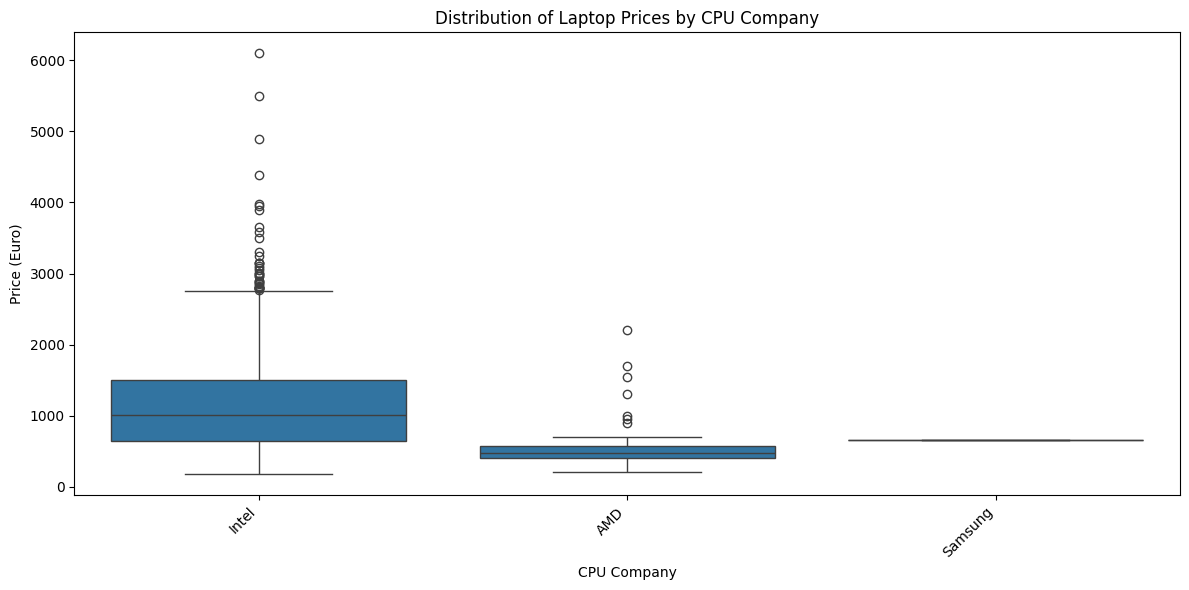

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='CPU_Company', y='Price (Euro)', data=data)
plt.title('Distribution of Laptop Prices by CPU Company')
plt.xlabel('CPU Company')
plt.ylabel('Price (Euro)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

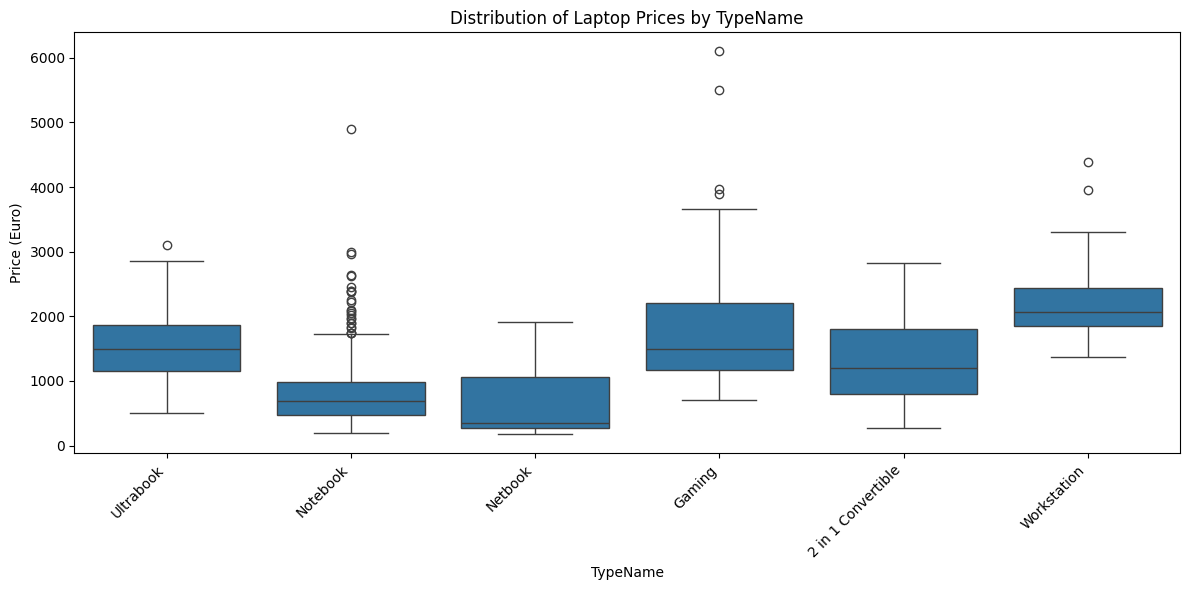

In [15]:

plt.figure(figsize=(12, 6))
sns.boxplot(x='TypeName', y='Price (Euro)', data=data)
plt.title('Distribution of Laptop Prices by TypeName')
plt.xlabel('TypeName')
plt.ylabel('Price (Euro)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

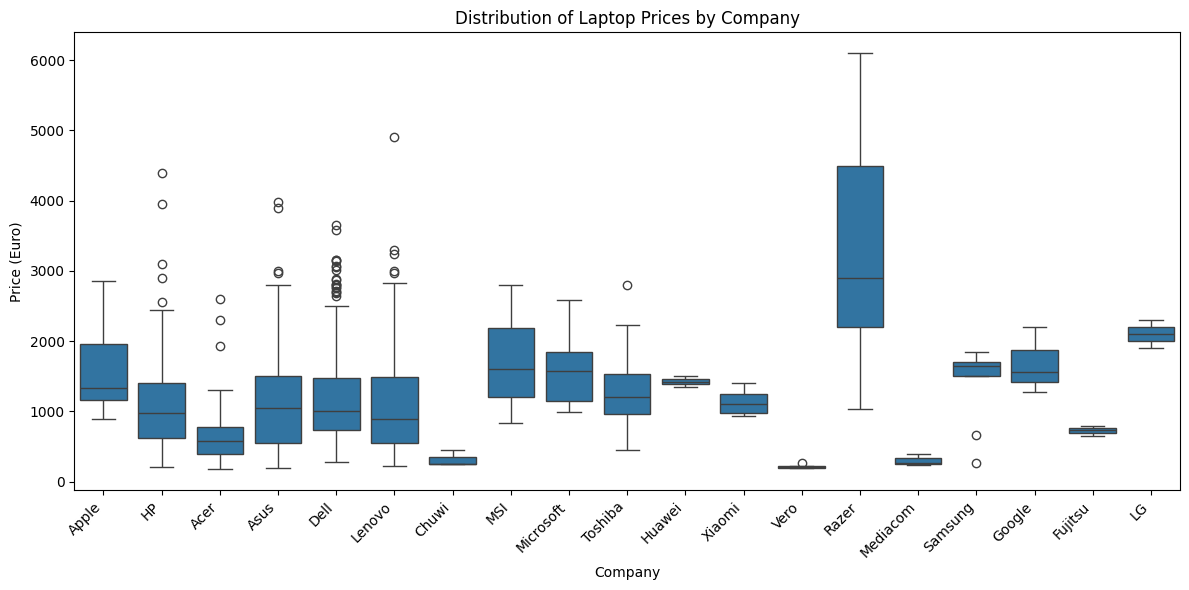

In [21]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Company', y='Price (Euro)', data=data)
plt.title('Distribution of Laptop Prices by Company')
plt.xlabel('Company')
plt.ylabel('Price (Euro)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [18]:
top_10_highest_price = data.sort_values(by=['Price (Euro)'], ascending=False).head(10)

display(top_10_highest_price)

,Company,Product,TypeName,Inches,ScreenResolution,CPU_Company,CPU_Type,CPU_Frequency (GHz),RAM (GB),Memory,GPU_Company,GPU_Type,OpSys,Weight (kg),Price (Euro)
196,Razer,Blade Pro,Gaming,17.3,4K Ultra HD / Touchscreen 3840x2160,Intel,Core i7 7820HK,2.9,32,1TB SSD,Nvidia,GeForce GTX 1080,Windows 10,3.49,6099.0
830,Razer,Blade Pro,Gaming,17.3,4K Ultra HD / Touchscreen 3840x2160,Intel,Core i7 7820HK,2.9,32,512GB SSD,Nvidia,GeForce GTX 1080,Windows 10,3.49,5499.0
610,Lenovo,Thinkpad P51,Notebook,15.6,IPS Panel 4K Ultra HD 3840x2160,Intel,Xeon E3-1535M v6,3.1,32,1TB SSD,Nvidia,Quadro M2200M,Windows 10,2.50,4899.0
749,HP,Zbook 17,Workstation,17.3,IPS Panel Full HD 1920x1080,Intel,Xeon E3-1535M v5,2.9,16,256GB SSD,Nvidia,Quadro M2000M,Windows 7,3.00,4389.0
1066,Asus,ROG G701VO,Gaming,17.3,IPS Panel Full HD 1920x1080,Intel,Core i7 6820HK,2.7,64,1TB SSD,Nvidia,GeForce GTX 980,Windows 10,3.58,3975.0
1136,HP,ZBook 17,Workstation,17.3,IPS Panel Full HD 1920x1080,Intel,Core i7 6700HQ,2.6,8,256GB SSD,Nvidia,Quadro M3000M,Windows 7,3.00,3949.4
238,Asus,ROG G703VI-E5062T,Gaming,17.3,Full HD 1920x1080,Intel,Core i7 7820HK,2.9,32,512GB SSD + 1TB HDD,Nvidia,GeForce GTX 1080,Windows 10,4.70,3890.0
723,Dell,Alienware 17,Gaming,17.3,4K Ultra HD 3840x2160,Intel,Core i7 7700HQ,2.8,32,1TB SSD + 1TB HDD,Nvidia,GeForce GTX 1070,Windows 10,4.36,3659.4
780,Dell,Alienware 17,Gaming,17.3,IPS Panel Full HD 1920x1080,Intel,Core i7 7700HQ,2.8,32,1TB SSD + 1TB HDD,Nvidia,GeForce GTX 1070M,Windows 10,4.42,3588.8
1231,Razer,Blade Pro,Gaming,14.0,Full HD 1920x1080,Intel,Core i7 7700HQ,2.8,16,1TB SSD,Nvidia,GeForce GTX 1060,Windows 10,1.95,3499.0


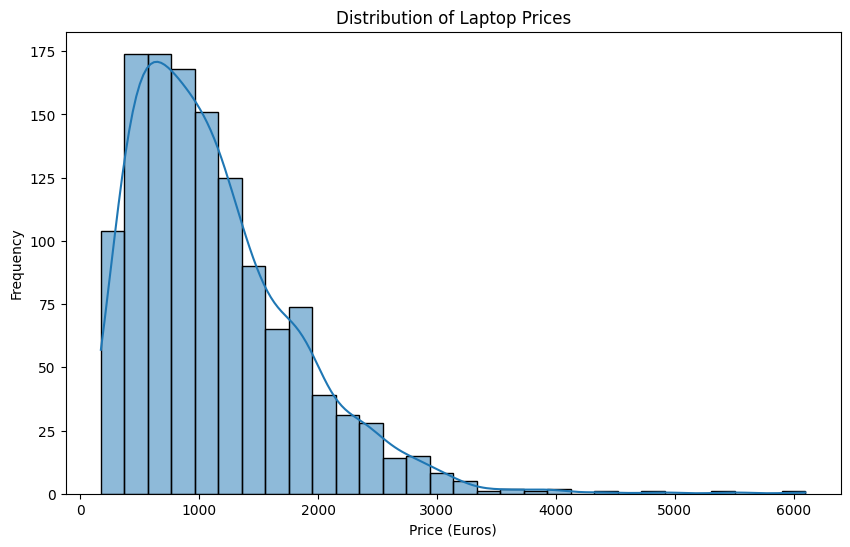

In [14]:
plt.figure(figsize=(10, 6))
sns.histplot(data['Price (Euro)'], bins=30, kde=True)
plt.title('Distribution of Laptop Prices')
plt.xlabel('Price (Euros)')
plt.ylabel('Frequency')
plt.show()

In [67]:
for col in data.columns:
    unique_count = data[col].nunique()
    print(f"Column '{col}' has {unique_count} unique values.")

Column 'Company' has 19 unique values.
Column 'Product' has 618 unique values.
Column 'TypeName' has 6 unique values.
Column 'Inches' has 18 unique values.
Column 'ScreenResolution' has 40 unique values.
Column 'CPU_Company' has 3 unique values.
Column 'CPU_Type' has 93 unique values.
Column 'CPU_Frequency (GHz)' has 25 unique values.
Column 'RAM (GB)' has 9 unique values.
Column 'Memory' has 39 unique values.
Column 'GPU_Company' has 4 unique values.
Column 'GPU_Type' has 106 unique values.
Column 'OpSys' has 9 unique values.
Column 'Weight (kg)' has 171 unique values.
Column 'Price (Euro)' has 791 unique values.


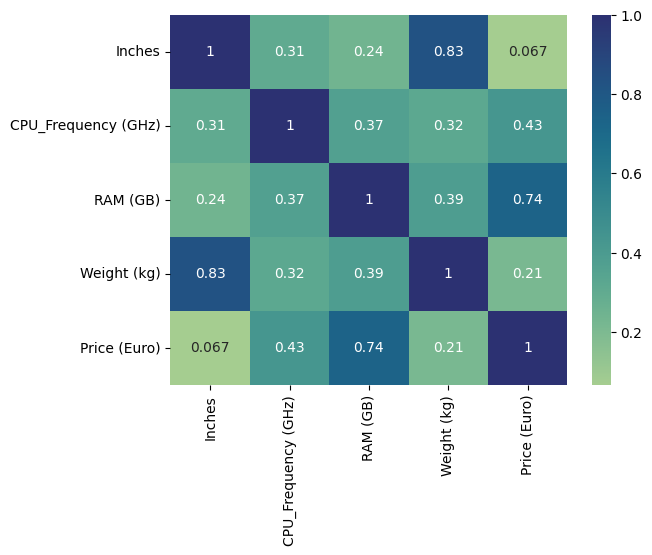

In [68]:
x = data.corr(numeric_only=True)

sns.heatmap(x, annot=True, cmap='crest')

plt.show()

Las caracteristicas que presentan una mayor correlatividad con el precio son la Ram y la frecuencia del CPU

In [24]:
encoder = LabelEncoder()

data['Company'] = encoder.fit_transform(data['Company'])
data['Product'] = encoder.fit_transform(data['Product'])
data['TypeName'] = encoder.fit_transform(data['TypeName'])
data['ScreenResolution'] = encoder.fit_transform(data['ScreenResolution'])
data['CPU_Company'] = encoder.fit_transform(data['CPU_Company'])
data['CPU_Type'] = encoder.fit_transform(data['CPU_Type'])
data['Memory'] = encoder.fit_transform(data['Memory'])
data['GPU_Company'] = encoder.fit_transform(data['GPU_Company'])
data['GPU_Type'] = encoder.fit_transform(data['GPU_Type'])
data['OpSys'] = encoder.fit_transform(data['OpSys'])

In [25]:
display(data)

,Company,Product,TypeName,Inches,ScreenResolution,CPU_Company,CPU_Type,CPU_Frequency (GHz),RAM (GB),Memory,GPU_Company,GPU_Type,OpSys,Weight (kg),Price (Euro)
0,1,300,4,13.3,23,1,40,2.3,8,4,2,56,8,1.37,1339.69
1,1,301,4,13.3,1,1,40,1.8,8,2,2,50,8,1.34,898.94
2,7,50,3,15.6,8,1,46,2.5,8,16,2,52,4,1.86,575.00
3,1,300,4,15.4,25,1,54,2.7,16,29,0,76,8,1.83,2537.45
4,1,300,4,13.3,23,1,40,3.1,8,16,2,57,8,1.37,1803.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1270,10,580,0,14.0,13,1,55,2.5,4,4,2,46,5,1.80,638.00
1271,10,588,0,13.3,19,1,55,2.5,16,29,2,46,5,1.30,1499.00
1272,10,196,3,14.0,0,1,20,1.6,2,35,2,39,5,1.50,229.00
1273,7,2,3,15.6,0,1,55,2.5,6,10,0,88,5,2.19,764.00


In [26]:
data.describe()

,Company,Product,TypeName,Inches,ScreenResolution,CPU_Company,CPU_Type,CPU_Frequency (GHz),RAM (GB),Memory,GPU_Company,GPU_Type,OpSys,Weight (kg),Price (Euro)
count,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000
mean,6.460392,307.334902,2.582745,15.022902,9.316863,0.953725,50.250980,2.302980,8.440784,16.288627,2.036863,47.280784,4.814118,2.040525,1134.969059
std,4.096247,171.162972,1.247925,1.429470,7.877197,0.213864,16.982392,0.503846,5.097809,7.935562,0.925510,26.034717,1.034319,0.669196,700.752504
min,0.000000,0.000000,0.000000,10.100000,0.000000,0.000000,0.000000,0.900000,2.000000,0.000000,0.000000,0.000000,0.000000,0.690000,174.000000
25%,4.000000,180.500000,1.000000,14.000000,7.000000,1.000000,41.000000,2.000000,4.000000,10.000000,2.000000,28.000000,5.000000,1.500000,609.000000
50%,7.000000,291.000000,3.000000,15.600000,8.000000,1.000000,52.000000,2.500000,8.000000,16.000000,2.000000,46.000000,5.000000,2.040000,989.000000
75%,10.000000,454.500000,3.000000,15.600000,15.000000,1.000000,62.000000,2.700000,8.000000,23.000000,3.000000,52.000000,5.000000,2.310000,1496.500000
max,18.000000,617.000000,5.000000,18.400000,39.000000,2.000000,92.000000,3.600000,64.000000,38.000000,3.000000,105.000000,8.000000,4.700000,6099.000000


#Sin normalizar

In [27]:
X = data.drop(columns=['Price (Euro)'])
y = data['Price (Euro)']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Regresion Lineal

In [28]:
# Regresion lineal
from sklearn import linear_model
regr = linear_model.LinearRegression()

# Entrenamos y evaluamos con los datos de train

regr.fit(X_train, y_train)
regr.score(X_train,y_train)

0.686513246956034

In [29]:
prediccion = regr.predict(X_test)
regr.score(X_test,y_test)

0.6950334104560065

Estos resultados indican que el modelo no esta sobreentrenado pero no es lo suficientemente bueno

In [31]:
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

modelo=sm.OLS(y_train, X_train)
result=modelo.fit()
result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           Price (Euro)   R-squared (uncentered):                   0.912
Model:                            OLS   Adj. R-squared (uncentered):              0.911
Method:                 Least Squares   F-statistic:                              742.2
Date:                Fri, 20 Dec 2024   Prob (F-statistic):                        0.00
Time:                        11:26:19   Log-Likelihood:                         -7541.7
No. Observations:                1020   AIC:                                  1.511e+04
Df Residuals:                    1006   BIC:                                  1.518e+04
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Company                 7.9997      3.210      2.492      0.013       1.700      14.299
Product                 0.1576      0.078      2.011      0.045       0.004       0.311
TypeName               43.0211     11.297      3.808      0.000      20.853      65.189
Inches               -124.6007      9.797    -12.718      0.000    -143.826    -105.375
ScreenResolution        9.3098      1.696      5.490      0.000       5.982      12.637
CPU_Company            86.0789     68.131      1.263      0.207     -47.616     219.774
CPU_Type                5.4852      0.884      6.206      0.000       3.751       7.220
CPU_Frequency (GHz)   251.0070     29.008      8.653      0.000     194.083     307.930
RAM (GB)               73.4346      3.149     23.318      0.000      67.255      79.615
Memory                  5.9421      1.583      3.753      0.000       2.835       9.049
GPU_Company            93.2521     21.724      4.293      0.000      50.622     135.882
GPU_Type                2.3192      0.704      3.296      0.001       0.938       3.700
OpSys                  82.2062     12.520      6.566      0.000      57.637     106.775
Weight (kg)           180.4858     33.593      5.373      0.000     114.566     246.405
==============================================================================
Omnibus:                      271.279   Durbin-Watson:                   1.897
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1231.613
Skew:                           1.168   Prob(JB):                    3.62e-268
Kurtosis:                       7.850   Cond. No.                     2.01e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.01e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [24]:
# Con Constante
train_data_X = sm.add_constant(X_train)
modelo=sm.OLS(y_train, train_data_X)
result=modelo.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Price (Euro)   R-squared:                       0.687
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     157.2
Date:                Fri, 20 Dec 2024   Prob (F-statistic):          1.74e-241
Time:                        08:37:02   Log-Likelihood:                -7536.5
No. Observations:                1020   AIC:                         1.510e+04
Df Residuals:                    1005   BIC:                         1.518e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                -767.3132    238.165     -3.222      0.001   -1234.671    -299.956
Company                 7.9456      3.195      2.487      0.013       1.675      14.216
Product                 0.1565      0.078      2.006      0.045       0.003       0.309
TypeName               41.4390     11.255      3.682      0.000      19.352      63.526
Inches                -80.1192     16.903     -4.740      0.000    -113.289     -46.949
ScreenResolution       10.5535      1.731      6.095      0.000       7.156      13.951
CPU_Company           172.2414     72.898      2.363      0.018      29.191     315.292
CPU_Type                4.9437      0.896      5.520      0.000       3.186       6.701
CPU_Frequency (GHz)   268.8720     29.402      9.145      0.000     211.177     326.567
RAM (GB)               72.8554      3.140     23.203      0.000      66.694      79.017
Memory                  7.0721      1.615      4.380      0.000       3.904      10.241
GPU_Company           110.4542     22.273      4.959      0.000      66.747     154.161
GPU_Type                3.2180      0.754      4.268      0.000       1.739       4.697
OpSys                  87.1582     12.557      6.941      0.000      62.518     111.799
Weight (kg)           121.5050     38.121      3.187      0.001      46.700     196.310
==============================================================================
Omnibus:                      268.457   Durbin-Watson:                   1.886
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1217.681
Skew:                           1.155   Prob(JB):                    3.84e-265
Kurtosis:                       7.829   Cond. No.                     6.99e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.99e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#DecisionTree

In [32]:
from sklearn.tree import DecisionTreeRegressor

# Definimos el modelo y el numero maximo de ramas del arbol.

arbol = DecisionTreeRegressor(criterion='squared_error', max_depth=8, max_features=None, max_leaf_nodes=None,min_impurity_decrease=0.0,min_samples_leaf=10, min_samples_split=2, min_weight_fraction_leaf=0.0, random_state=None, splitter='best')

# Entrenamos y evaluamos con los datos de train

arbol=arbol.fit(X_train, y_train)
arbol.score(X_train, y_train)
# Realizamos la prediccion
# Evaluamos en los datos de test.


0.8210071047429829

In [33]:
prediccionarbol = arbol.predict(X_test)
arbol.score(X_test, y_test)

0.6656414251083927

Esta diferencia en las metricas indica que el modelo esta sobreentrenado

In [34]:
importancias=pd.DataFrame(arbol.feature_importances_)
importancias.index=(X.columns)
importancias.sort_values(by=0, ascending=False)

,0
RAM (GB),0.701606
Weight (kg),0.056305
TypeName,0.054960
Product,0.052071
CPU_Frequency (GHz),0.038240
Company,0.021833
ScreenResolution,0.021556
Inches,0.018368
GPU_Type,0.015330
CPU_Type,0.012616


#RandomForest

In [38]:
from sklearn.ensemble import RandomForestRegressor

RF= RandomForestRegressor(n_estimators=500, criterion='squared_error' ,max_features='sqrt' ,max_depth=30, min_samples_split=2, min_samples_leaf=3, max_leaf_nodes=None,min_impurity_decrease=0, bootstrap=True, oob_score=True, n_jobs=1, random_state=None, verbose=0, warm_start=False)

clf = RF.fit(X_train,y_train)
# Analizamos la fiabilidad sobre los datos utilizados para crear el modelo.

RF.score(X_train,y_train)


0.9058640367490742

In [40]:
y_test_pred = RF.predict(X_test)
test_score = r2_score(y_test, y_test_pred)
print(f"Testing R² Score: {test_score}")

Testing R² Score: 0.8344144958899027


In [41]:
# El ultimo paso es determinar la importancia de cada una de las variables

importancias=pd.DataFrame(clf.feature_importances_)
importancias.index=(X.columns)
importancias.sort_values(by=0, ascending=False)


,0
RAM (GB),0.253765
CPU_Type,0.141756
Weight (kg),0.110078
CPU_Frequency (GHz),0.107730
ScreenResolution,0.073718
TypeName,0.068276
Product,0.058184
Memory,0.050733
GPU_Type,0.042325
Inches,0.036929


In [78]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score, r2_score
import numpy as np

# Fit the model using training data
clf.fit(X_train, y_train)

# Predict values for both training and testing sets
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

# Metrics for Training Set
print("Training Set Metrics:")
print("R² Score (Train):", r2_score(y_train, y_train_pred))
print("Mean Absolute Error (MAE):", mean_absolute_error(y_train, y_train_pred))
print("Mean Squared Error (MSE):", mean_squared_error(y_train, y_train_pred))
print("Root Mean Squared Error (RMSE):", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("Explained Variance Score:", explained_variance_score(y_train, y_train_pred))

# Metrics for Testing Set
print("\nTesting Set Metrics:")
print("R² Score (Test):", r2_score(y_test, y_test_pred))
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_test_pred))
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_test_pred))
print("Root Mean Squared Error (RMSE):", np.sqrt(mean_squared_error(y_test, y_test_pred)))
print("Explained Variance Score:", explained_variance_score(y_test, y_test_pred))

Training Set Metrics:
R² Score (Train): 0.9049930854432193
Mean Absolute Error (MAE): 130.7139897776862
Mean Squared Error (MSE): 46432.062219310064
Root Mean Squared Error (RMSE): 215.48100199161425
Explained Variance Score: 0.9049940576922151

Testing Set Metrics:
R² Score (Test): 0.8399861765140153
Mean Absolute Error (MAE): 168.8988328132144
Mean Squared Error (MSE): 79421.14510230033
Root Mean Squared Error (RMSE): 281.8175741544525
Explained Variance Score: 0.8400677646805719


Los modelos de RandomForest y XGBoost ofrecen los mejores resultados, además de significativas similitudes en la importancia de las caracteristicas, puesto que las dos primeras coinciden

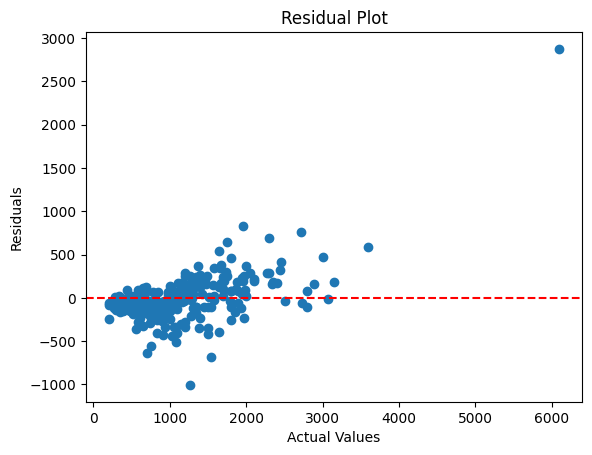

In [42]:
import matplotlib.pyplot as plt
residuals = y_test - y_test_pred
plt.scatter(y_test, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

#RandomForest sin los 10 precios extremos

In [44]:
# Create a copy of the DataFrame
data_no_top10 = data.copy()

# Remove the top 10 highest price rows
data_no_top10 = data_no_top10.drop(top_10_highest_price.index)

# Display the new DataFrame (optional)
display(data_no_top10)

,Company,Product,TypeName,Inches,ScreenResolution,CPU_Company,CPU_Type,CPU_Frequency (GHz),RAM (GB),Memory,GPU_Company,GPU_Type,OpSys,Weight (kg),Price (Euro)
0,1,300,4,13.3,23,1,40,2.3,8,4,2,56,8,1.37,1339.69
1,1,301,4,13.3,1,1,40,1.8,8,2,2,50,8,1.34,898.94
2,7,50,3,15.6,8,1,46,2.5,8,16,2,52,4,1.86,575.00
3,1,300,4,15.4,25,1,54,2.7,16,29,0,76,8,1.83,2537.45
4,1,300,4,13.3,23,1,40,3.1,8,16,2,57,8,1.37,1803.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1270,10,580,0,14.0,13,1,55,2.5,4,4,2,46,5,1.80,638.00
1271,10,588,0,13.3,19,1,55,2.5,16,29,2,46,5,1.30,1499.00
1272,10,196,3,14.0,0,1,20,1.6,2,35,2,39,5,1.50,229.00
1273,7,2,3,15.6,0,1,55,2.5,6,10,0,88,5,2.19,764.00


In [45]:
Xr = data_no_top10.drop(columns=['Price (Euro)'])
yr = data_no_top10['Price (Euro)']

# Split into training and testing sets
Xr_train, Xr_test, yr_train, yr_test = train_test_split(Xr, yr, test_size=0.2, random_state=42)

In [53]:
from sklearn.ensemble import RandomForestRegressor

RF= RandomForestRegressor(n_estimators=500, criterion='squared_error' ,max_features='sqrt' ,max_depth=30, min_samples_split=2, min_samples_leaf=3, max_leaf_nodes=None,min_impurity_decrease=0, bootstrap=True, oob_score=True, n_jobs=1, random_state=None, verbose=0, warm_start=False)

clf = RF.fit(Xr_train,yr_train)
# Analizamos la fiabilidad sobre los datos utilizados para crear el modelo.

RF.score(Xr_train,yr_train)

0.9155453681468828

In [54]:
yr_test_pred = RF.predict(Xr_test)
test_score = r2_score(yr_test, yr_test_pred)
print(f"Testing R² Score: {test_score}")

Testing R² Score: 0.8485270314785904


In [51]:
importancias=pd.DataFrame(clf.feature_importances_)
importancias.index=(X.columns)
importancias.sort_values(by=0, ascending=False)

,0
RAM (GB),0.235699
CPU_Type,0.150463
Weight (kg),0.103132
CPU_Frequency (GHz),0.101332
ScreenResolution,0.084823
TypeName,0.074082
Memory,0.067007
Product,0.057294
GPU_Type,0.039928
Inches,0.037113


Al eliminar 10 valores extremos aumenta la R2 del training y aumenta ligeramente la R2 del testing, por tanto los valores extremos no afectan significativamente la capacidad predictiva del modelo

#Probando otro encoding

In [22]:

from sklearn.preprocessing import OneHotEncoder

# Create a OneHotEncoder object
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Fit and transform the categorical features
categorical_cols = ['Company', 'Product', 'TypeName', 'ScreenResolution', 'CPU_Company', 'CPU_Type', 'Memory', 'GPU_Company', 'GPU_Type', 'OpSys']
encoded_features = encoder.fit_transform(data[categorical_cols])

# Create a new DataFrame with the encoded features
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_cols))

# Drop the original categorical columns from the data DataFrame
data = data.drop(columns=categorical_cols)

# Concatenate the encoded DataFrame with the original DataFrame and name it differently
data_other_encoding = pd.concat([data, encoded_df], axis=1)

In [23]:
display(data_other_encoding)

,Inches,CPU_Frequency (GHz),RAM (GB),Weight (kg),Price (Euro),Company_0,Company_1,Company_2,Company_3,Company_4,...,GPU_Type_105,OpSys_0,OpSys_1,OpSys_2,OpSys_3,OpSys_4,OpSys_5,OpSys_6,OpSys_7,OpSys_8
0,13.3,2.3,8,1.37,1339.69,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,13.3,1.8,8,1.34,898.94,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,15.6,2.5,8,1.86,575.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,15.4,2.7,16,1.83,2537.45,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,13.3,3.1,8,1.37,1803.60,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1270,14.0,2.5,4,1.80,638.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1271,13.3,2.5,16,1.30,1499.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1272,14.0,1.6,2,1.50,229.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1273,15.6,2.5,6,2.19,764.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [24]:
X = data_other_encoding.drop(columns=['Price (Euro)'])
y = data_other_encoding['Price (Euro)']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Regresion Lineal

In [25]:
# Regresion lineal
from sklearn import linear_model
regr = linear_model.LinearRegression()

# Entrenamos y evaluamos con los datos de train

regr.fit(X_train, y_train)
regr.score(X_train,y_train)

0.9847855160781628

In [26]:
prediccion = regr.predict(X_test)
regr.score(X_test,y_test)

0.8188431070591647

#DecisionTree

In [27]:
from sklearn.tree import DecisionTreeRegressor

# Definimos el modelo y el numero maximo de ramas del arbol.

arbol = DecisionTreeRegressor(criterion='squared_error', max_depth=8, max_features=None, max_leaf_nodes=None,min_impurity_decrease=0.0,min_samples_leaf=10, min_samples_split=2, min_weight_fraction_leaf=0.0, random_state=None, splitter='best')

# Entrenamos y evaluamos con los datos de train

arbol=arbol.fit(X_train, y_train)
arbol.score(X_train, y_train)
# Realizamos la prediccion
# Evaluamos en los datos de test.

0.8147307494457472

In [28]:
prediccionarbol = arbol.predict(X_test)
arbol.score(X_test, y_test)

0.70435171257446

#RandomForest

In [30]:
from sklearn.ensemble import RandomForestRegressor

RF= RandomForestRegressor(n_estimators=500, criterion='squared_error' ,max_features='sqrt' ,max_depth=300, min_samples_split=10, min_samples_leaf=5, max_leaf_nodes=None,min_impurity_decrease=0, bootstrap=True, oob_score=True, n_jobs=1, random_state=None, verbose=0, warm_start=False)

clf = RF.fit(X,y)
# Analizamos la fiabilidad sobre los datos utilizados para crear el modelo.

RF.score(X,y)

0.6605849481349485

In [31]:
# Procedemos a realizar validacion cruzada

from sklearn.model_selection import cross_val_score


scores = cross_val_score(RF, X, y, cv=10)

print(scores.mean())

0.5900016055788849


El OneHotEncoder altera significativamente la dimensionalidad del dataset añadiendo riesgo de sobreentrenamiento.

En el modelo de regresion lineal, el R2 de training indica sobreentrenamiento dada la gran cantidad de características y de acuerdo al R2 de test (0.8188) generaliza mejor respecto a la codificacion anterior.

En el modelo DecisionTree se observa una mejora en la R2 de test, que sugiere que generaliza mejor dado el mayor numero de características.

En el modelo RandomForest, dada sus metricas se puede concluir que la alteración en la dimensionalidad del dataset introduce "ruido", y reduce significativamente la capacidad de generalizacion del modelo